In [29]:
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset

import time
import torch.autograd
import matplotlib.pyplot as plt
import random
import os

#### Setting various hyperparameters which will be useful later

In [14]:
# Hyperparameters

RANDOM_SEED = 45
GENERATOR_LEARNING_RATE = 0.0003
DISCRIMINATOR_LEARNING_RATE = 0.0003
NUM_EPOCHS = 12
BATCH_SIZE = 128
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 64, 64, 3

#### Unzipping the folder which contains images

In [15]:
!unzip /content/img_align_celeba.zip

Archive:  /content/img_align_celeba.zip
  inflating: img_align_celeba/000001.jpg  
  inflating: img_align_celeba/000002.jpg  
  inflating: img_align_celeba/000003.jpg  
  inflating: img_align_celeba/000004.jpg  
  inflating: img_align_celeba/000005.jpg  
  inflating: img_align_celeba/000006.jpg  
  inflating: img_align_celeba/000007.jpg  
  inflating: img_align_celeba/000008.jpg  
  inflating: img_align_celeba/000009.jpg  
  inflating: img_align_celeba/000010.jpg  
  inflating: img_align_celeba/000011.jpg  
  inflating: img_align_celeba/000012.jpg  
  inflating: img_align_celeba/000013.jpg  
  inflating: img_align_celeba/000014.jpg  
  inflating: img_align_celeba/000015.jpg  
  inflating: img_align_celeba/000016.jpg  
  inflating: img_align_celeba/000017.jpg  
  inflating: img_align_celeba/000018.jpg  
  inflating: img_align_celeba/000019.jpg  
  inflating: img_align_celeba/000020.jpg  
  inflating: img_align_celeba/000021.jpg  
  inflating: img_align_celeba/000022.jpg  
  inflating: i

In [16]:

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
data_dir = '/content/img_align_celeba'

#### Defining the dataloader function which extracts training, validation and testing images from the folder

In [30]:
# loading the celebA dataset
## Targets are 40-dim vectors representing 40 different features
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image

def get_dataloaders(data_dir, batch_size, num_workers=0, validation_split=0.2, test_split=0.1, train_transforms=None, test_transforms=None):
    if train_transforms is None:
        train_transforms = transforms.Compose([transforms.ToTensor()])

    if test_transforms is None:
        test_transforms = transforms.Compose([transforms.ToTensor()])

    image_files = [f for f in os.listdir(data_dir) if f.endswith(".jpg")]
    random.shuffle(image_files)

    total_samples = len(image_files)
    num_validation = int(validation_split * total_samples)
    num_test = int(test_split * total_samples)

    train_files = image_files[num_validation + num_test:]
    validation_files = image_files[:num_validation]
    test_files = image_files[num_validation:num_validation + num_test]

    class CustomImageDataset(Dataset):
        def __init__(self, data_dir, file_list, transform=None):
            self.data_dir = data_dir
            self.file_list = file_list
            self.transform = transform

        def __len__(self):
            return len(self.file_list)

        def __getitem__(self, idx):
            img_name = os.path.join(self.data_dir, self.file_list[idx])
            image = Image.open(img_name)
            if self.transform:
                image = self.transform(image)
            return image

    train_dataset = CustomImageDataset(data_dir, train_files, transform=train_transforms)
    validation_dataset = CustomImageDataset(data_dir, validation_files, transform=test_transforms)
    test_dataset = CustomImageDataset(data_dir, test_files, transform=test_transforms)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

    return train_loader, validation_loader, test_loader


#### Defining various transforms that can be applied as well as initializing an object of the get_dataloaders class

In [31]:
customized_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((160, 160)),
    torchvision.transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_loader, valid_loader, test_loader = get_dataloaders(data_dir,
    batch_size=BATCH_SIZE,
    train_transforms=customized_transforms,
    test_transforms=customized_transforms,
    num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Dispalying the images which would be used for training

Image batch dimensions: torch.Size([128, 3, 64, 64])


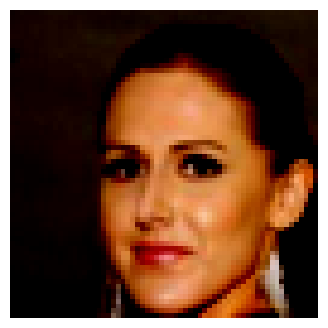

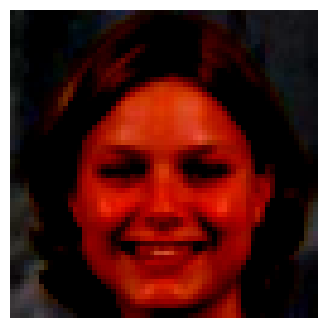

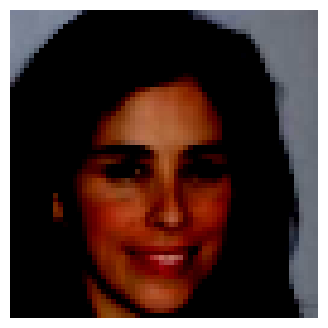

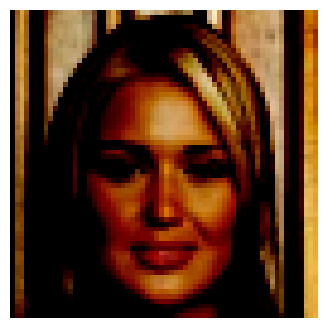

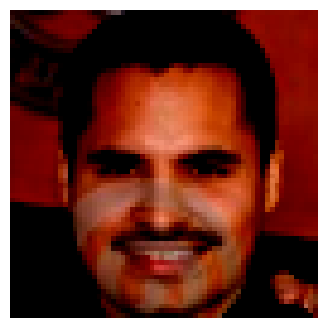

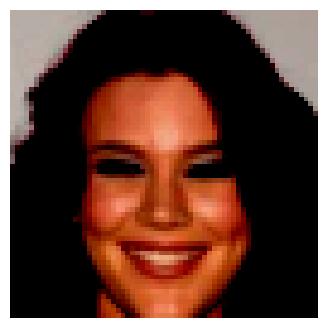

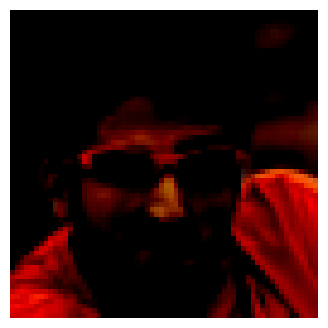

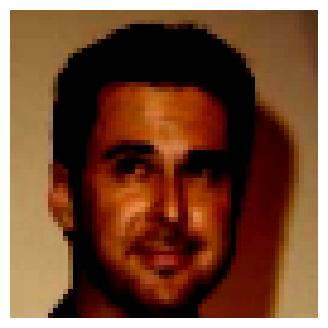

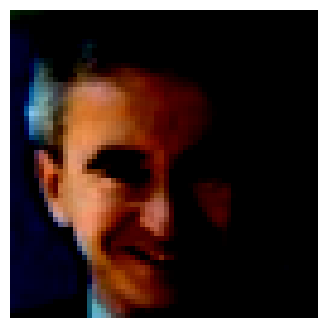

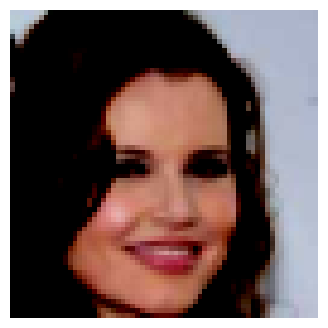

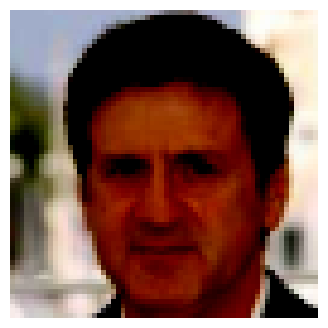

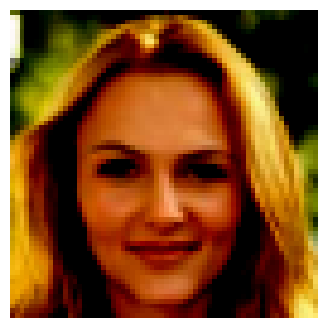

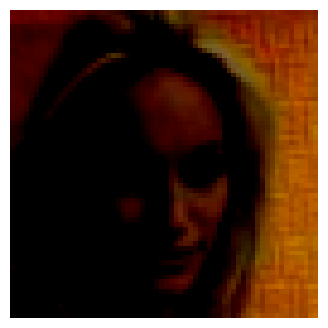

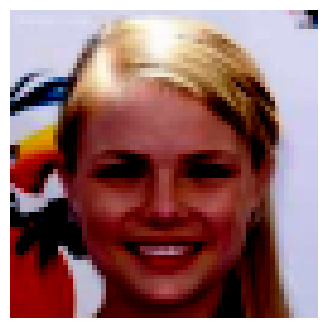

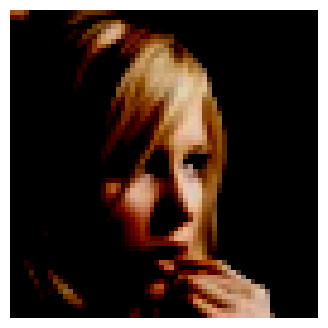

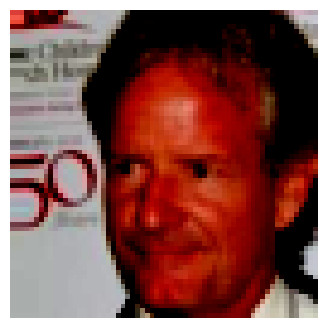

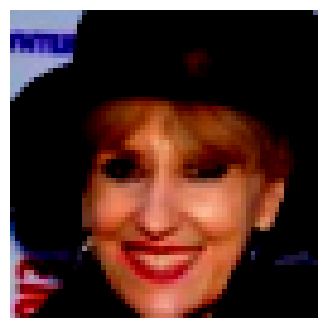

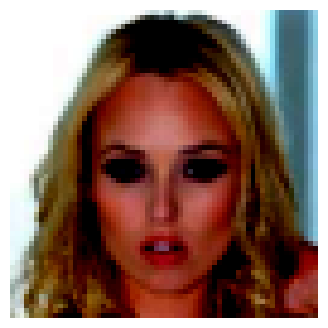

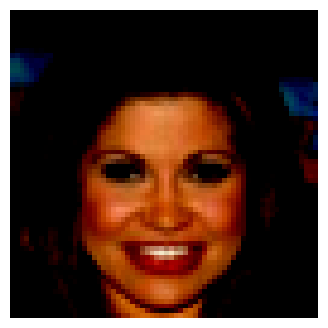

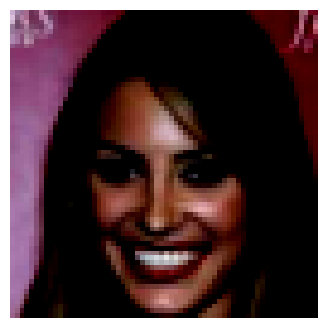

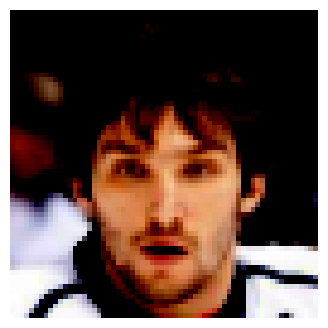

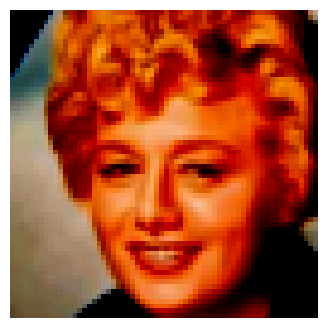

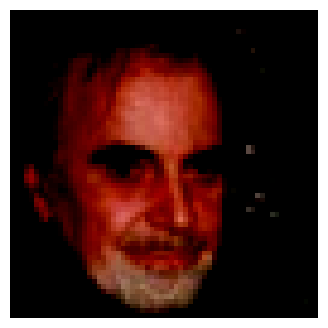

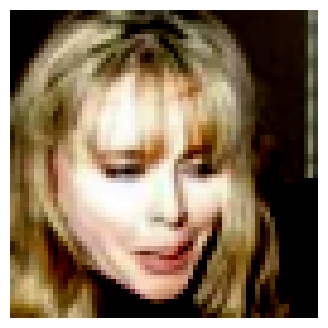

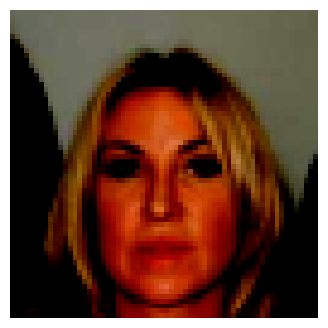

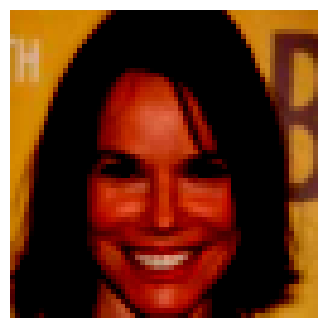

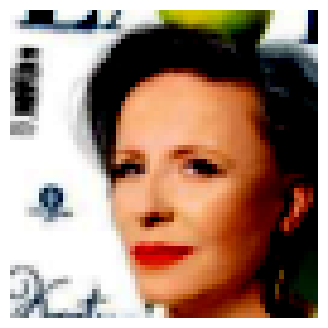

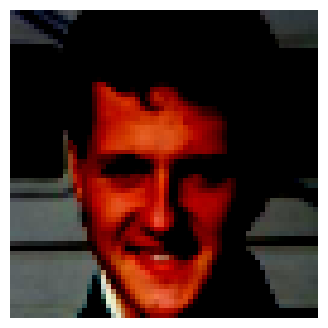

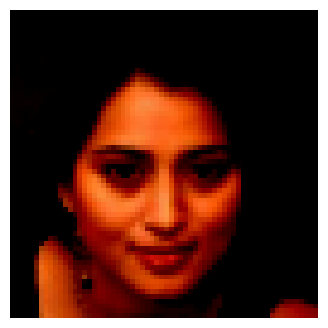

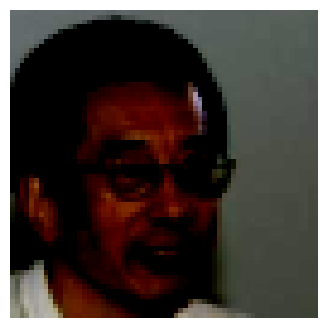

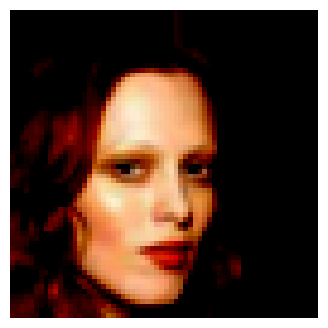

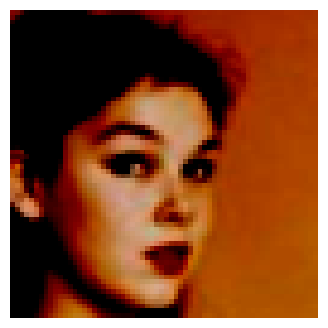

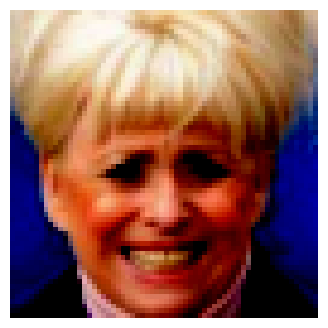

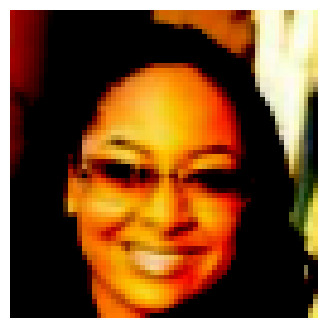

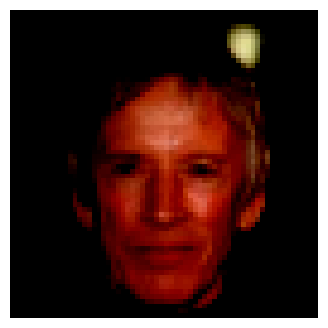

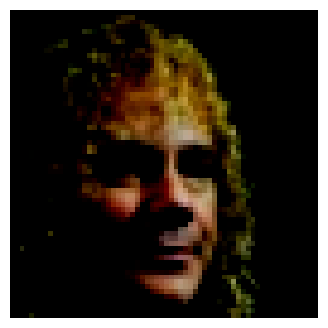

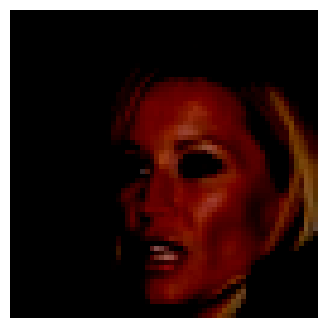

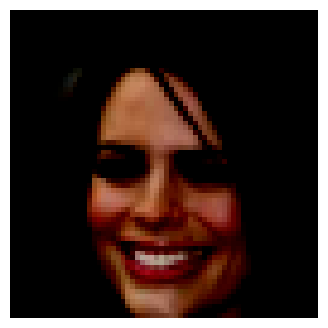

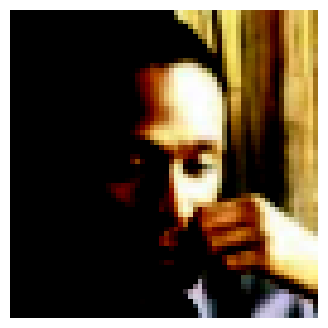

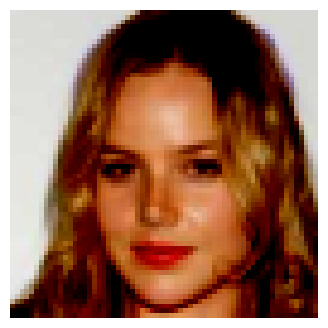

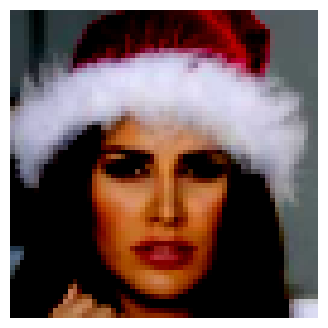

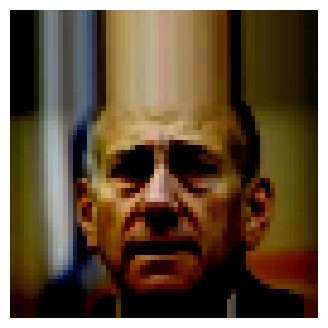

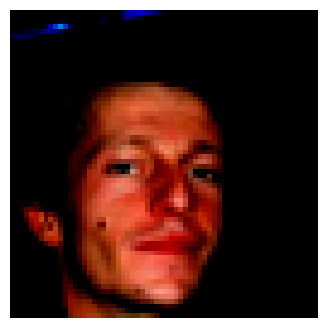

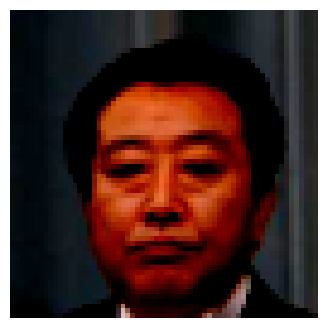

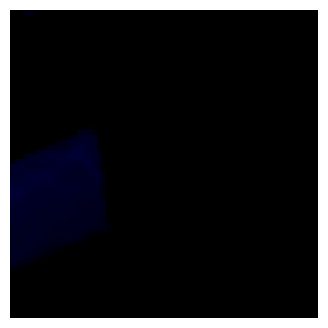

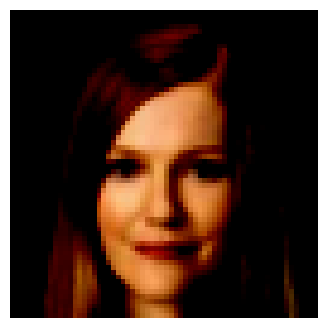

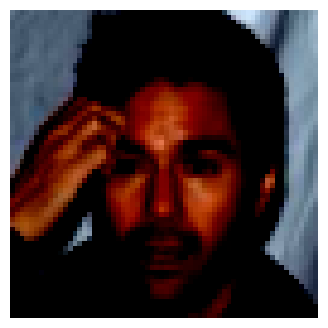

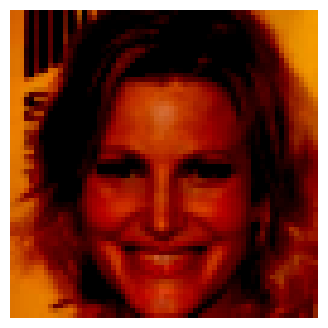

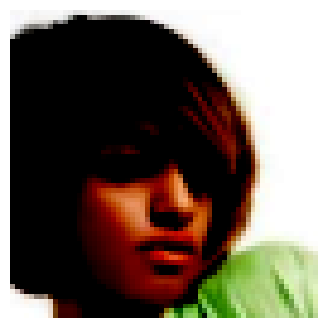

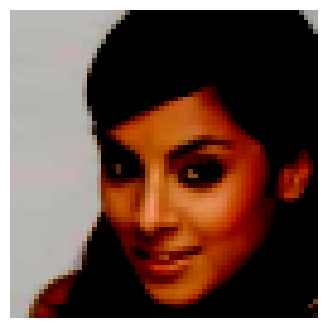

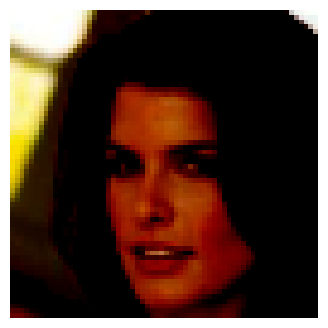

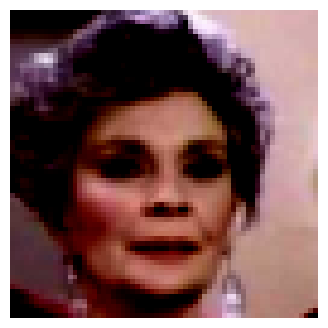

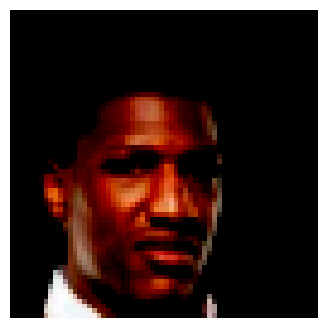

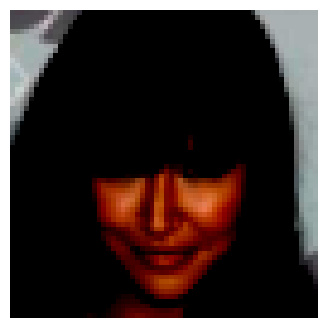

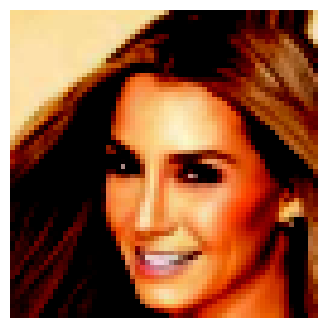

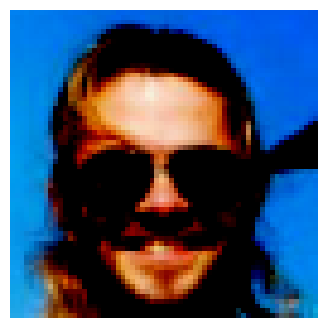

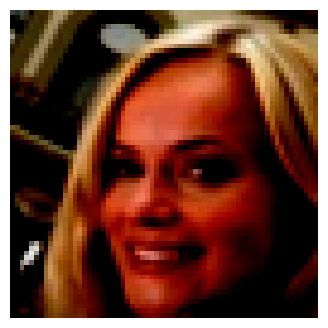

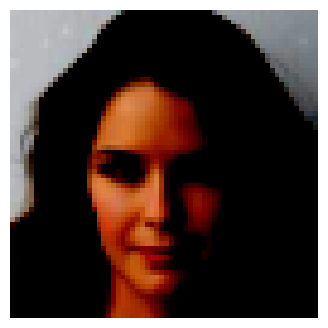

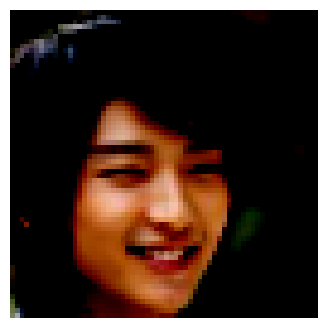

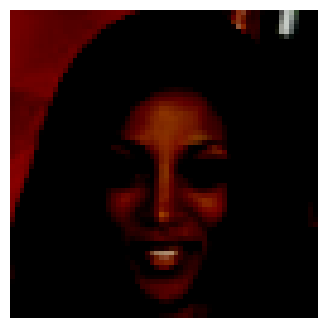

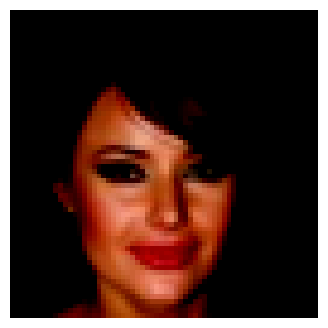

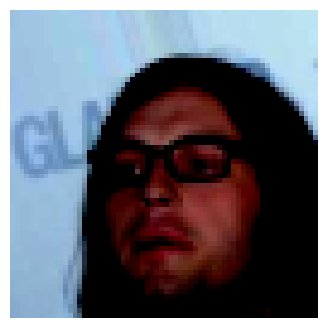

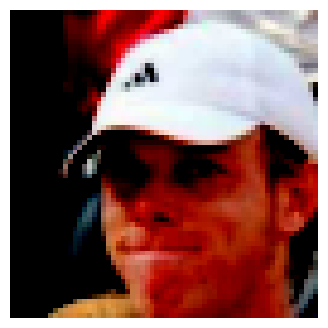

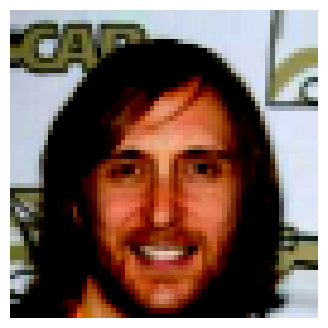

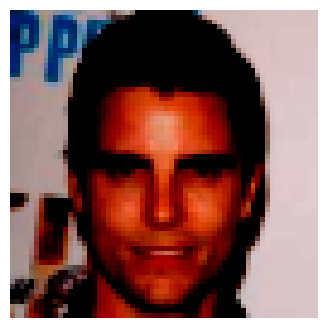

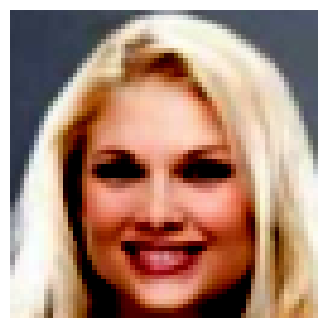

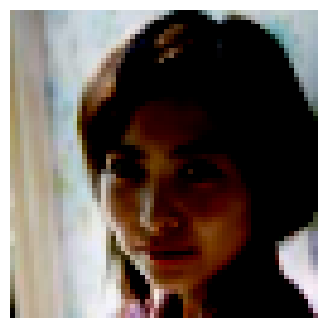

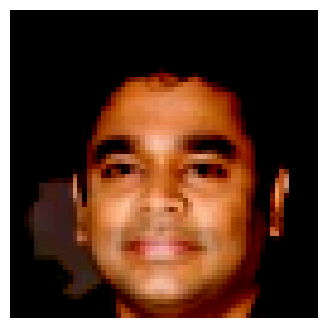

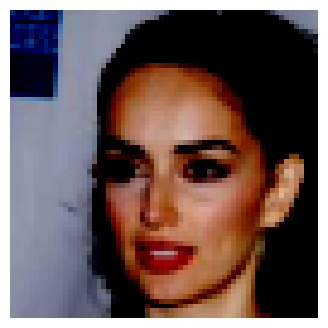

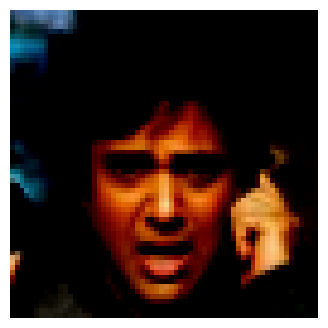

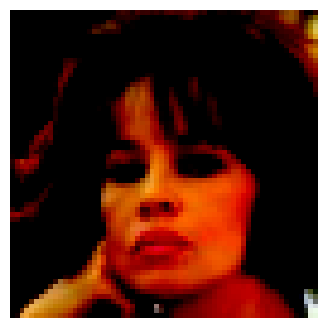

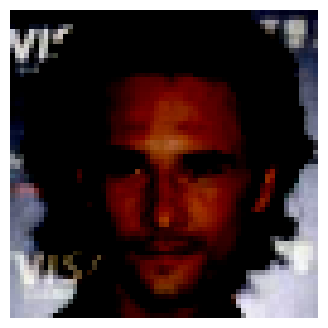

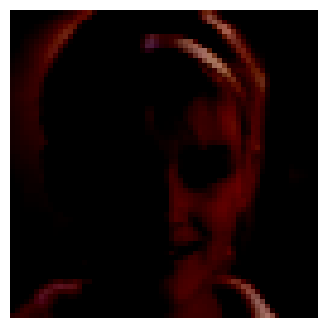

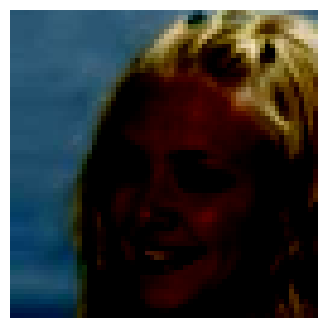

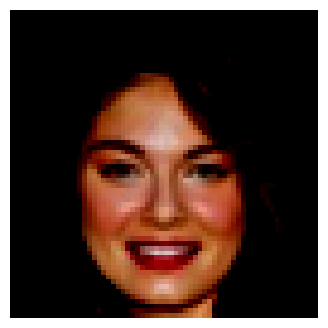

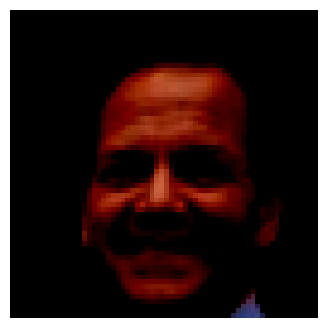

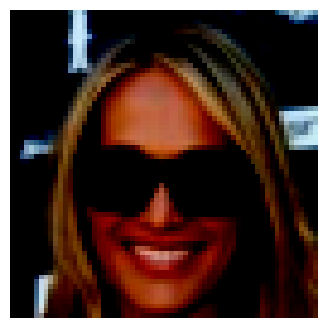

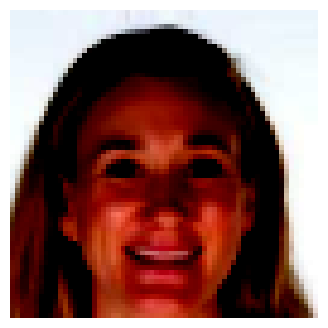

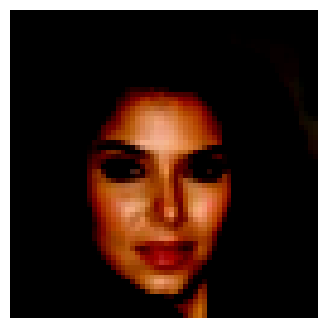

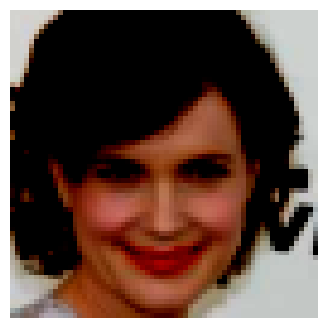

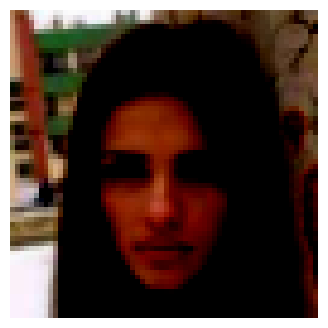

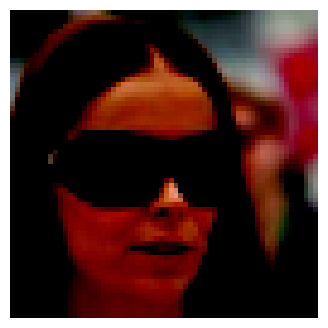

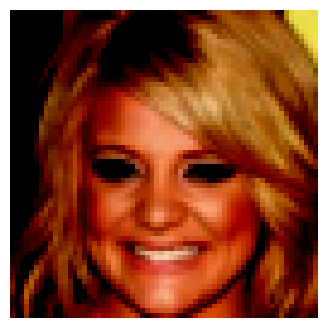

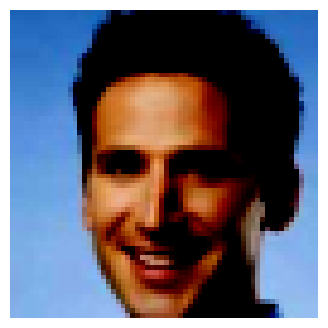

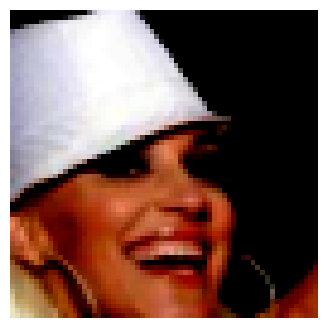

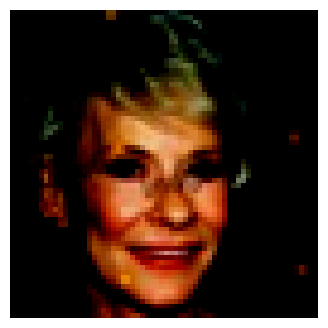

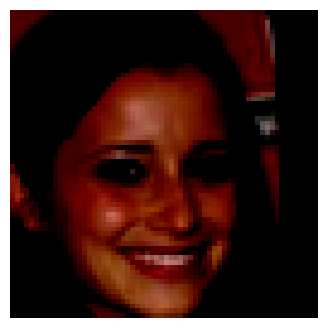

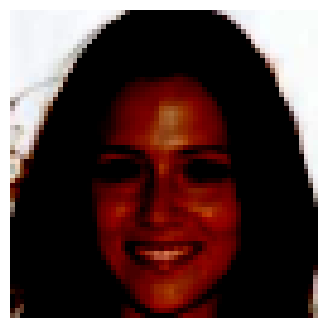

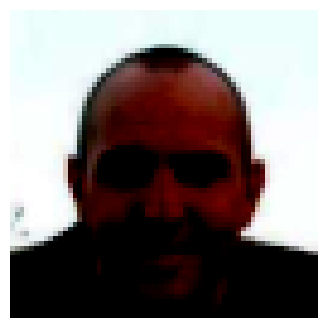

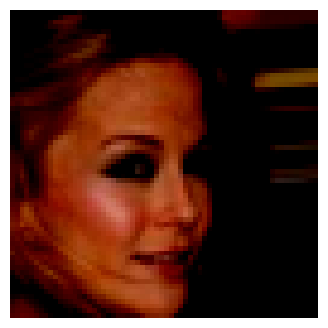

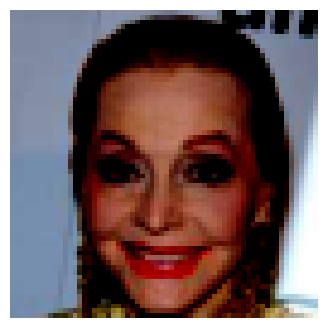

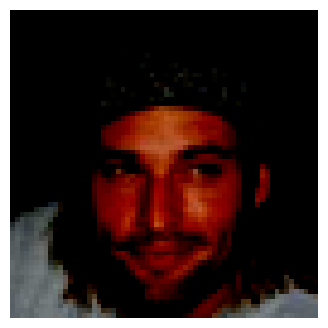

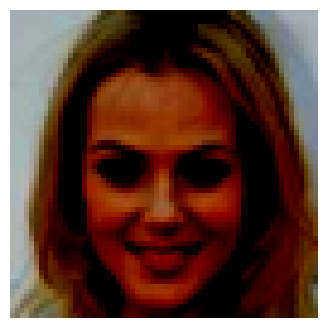

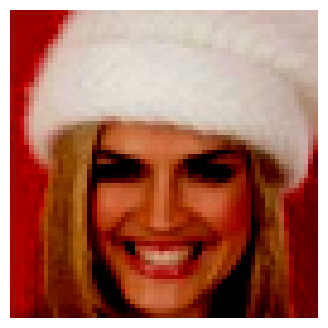

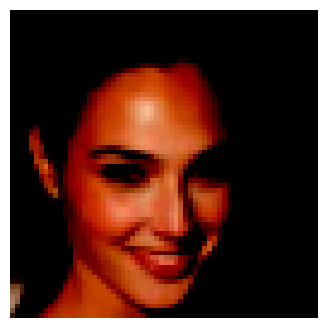

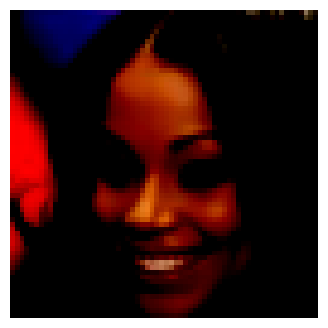

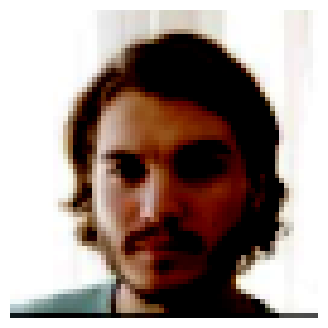

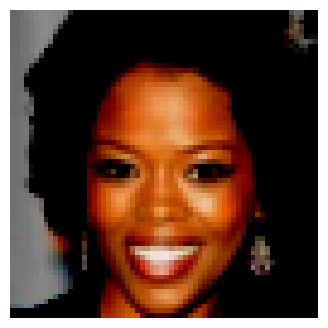

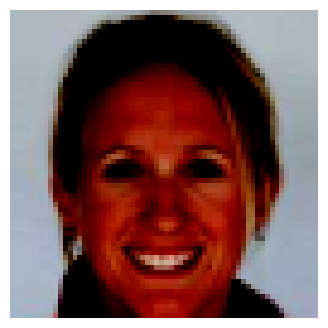

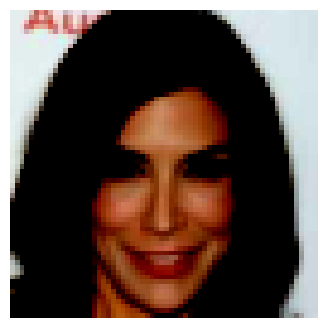

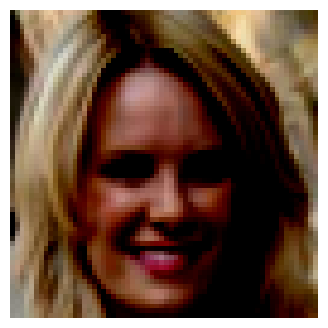

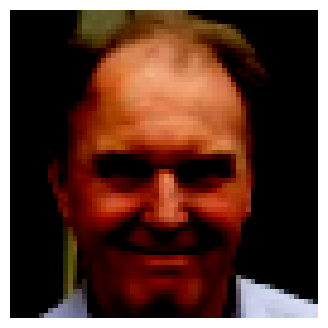

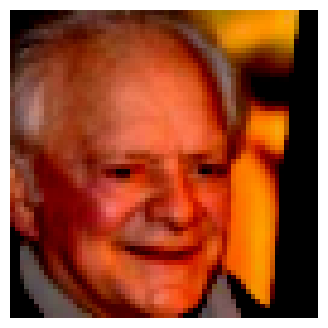

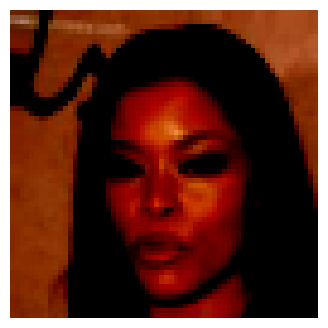

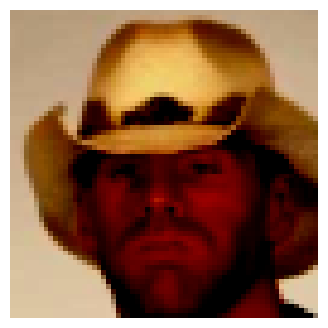

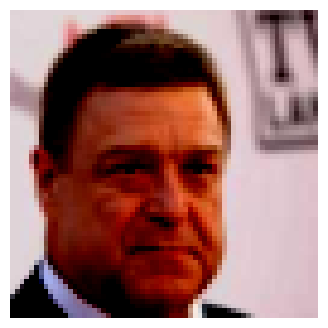

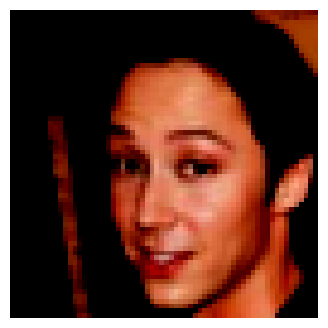

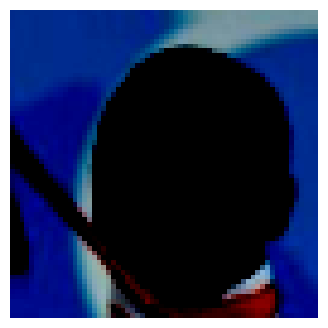

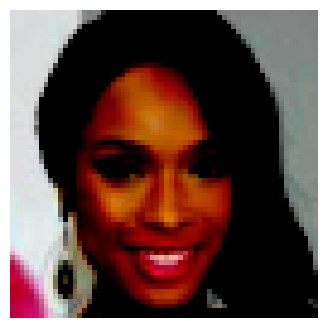

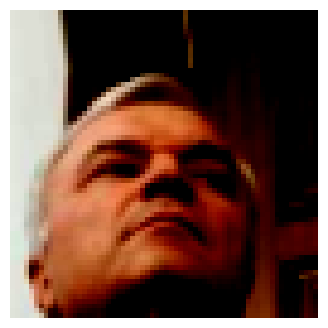

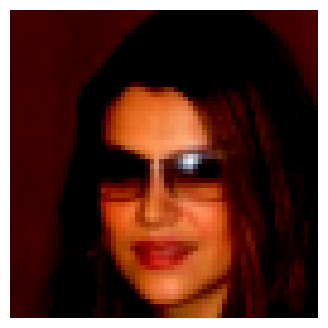

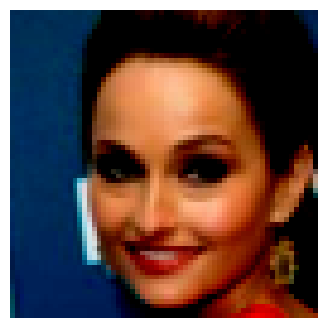

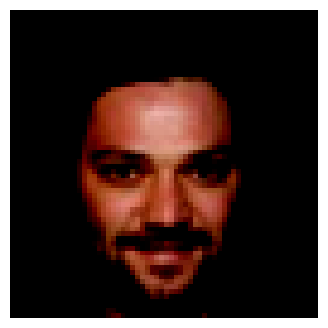

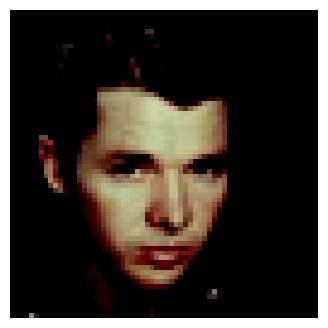

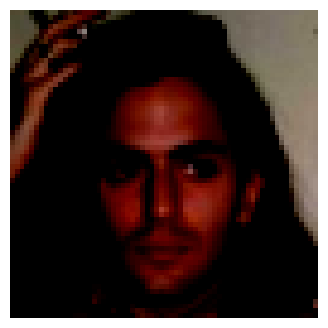

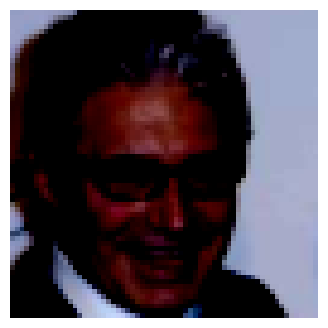

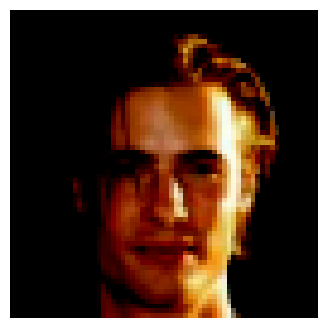

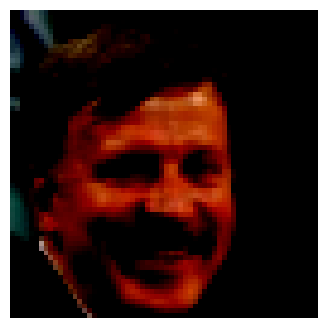

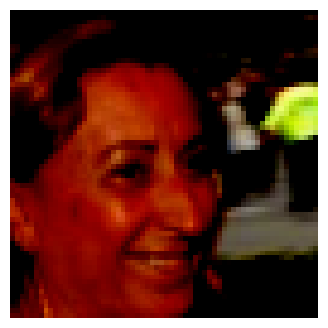

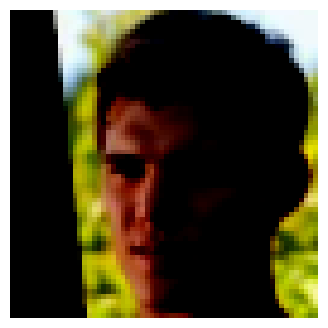

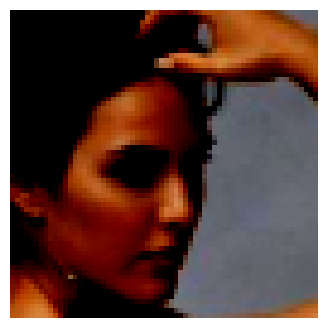

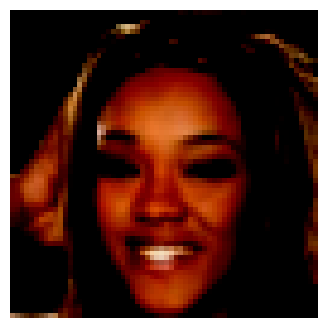

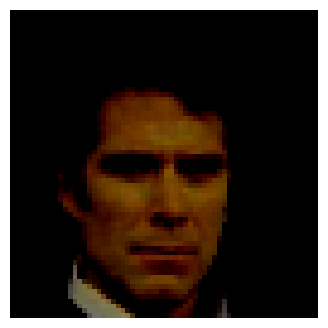

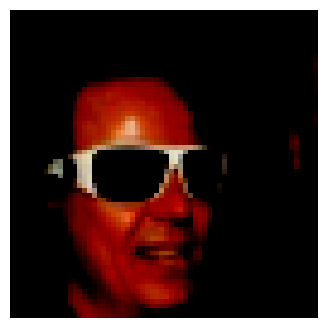

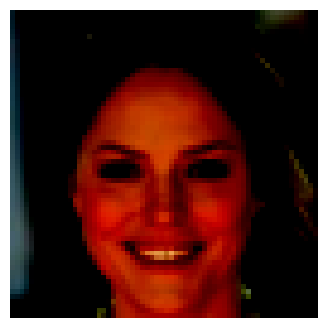

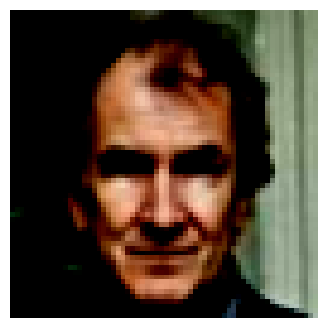

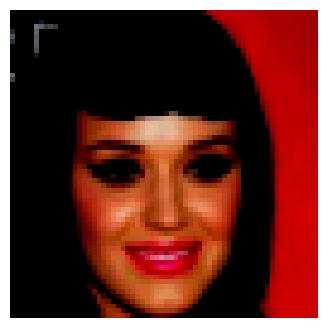

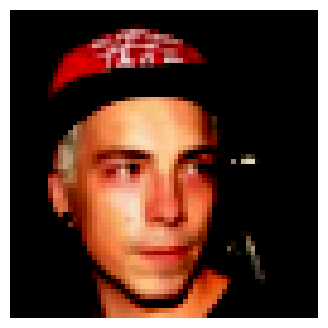

In [33]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

for batch in train_loader:
    images = batch  # You can access the images directly if DataLoader returns them as expected
    print('Image batch dimensions:', images.size())

    # You can also access individual images if needed
    for image in images:
        # Process each image if needed
        plt.figure(figsize=(4, 4))
        plt.axis("off")
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        plt.show()

    break  # Exit the loop after the first batch


#### Defining the generator and discriminator in DCGAN Class

In [34]:
class DCGAN(torch.nn.Module):

    def __init__(self, latent_dim=100,
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=3):
        super().__init__()


        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen*8, kernel_size=4, stride=1, padding=0, bias=False),
              nn.BatchNorm2d(num_feat_maps_gen*8),
              nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(num_feat_maps_gen*4),
              nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(num_feat_maps_gen*2),
              nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(num_feat_maps_gen),
              nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(num_feat_maps_gen, color_channels, kernel_size=4, stride=2, padding=1, bias=False),
              nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            nn.Conv2d(color_channels, num_feat_maps_dis, kernel_size=4, stride=2, padding=1),
              nn.LeakyReLU(inplace=True),
            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis*2, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(num_feat_maps_dis*2),
              nn.LeakyReLU(inplace=True),
            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(num_feat_maps_dis*4),
              nn.LeakyReLU(inplace=True),
            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*8, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(num_feat_maps_dis*8),
              nn.LeakyReLU(inplace=True),
            nn.Conv2d(num_feat_maps_dis*8, 1, kernel_size=4, stride=1, padding=0),
              nn.Flatten(),
        )


    def generator_forward(self, z):
        img = self.generator(z)
        return img

    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits

#### Using Adam Optimizer with DCGAN model for training both generator and discriminator

In [35]:
model = DCGAN()
optim_gen = torch.optim.Adam(model.generator.parameters(), betas=(0.5, 0.999), lr=GENERATOR_LEARNING_RATE)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), betas=(0.5, 0.999), lr=DISCRIMINATOR_LEARNING_RATE)

#### Defining the function to train GAN

In [50]:
def train_gan_v1(num_epochs, model, optimizer_gen, optimizer_discr,
                 latent_dim, train_loader, loss_fn=None,
                 logging_interval=100,
                 save_model=None):

    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    if loss_fn is None:
        loss_fn = F.binary_cross_entropy_with_logits

    # Batch of latent (noise) vectors for
    # evaluating / visualizing the training progress
    # of the generator
    device = 'cpu'
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)  # Format NCHW

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch in train_loader:  # Iterate over the batch directly
            features = batch  # The batch contains your features
            batch_size = features.size(0)

            # Real images
            real_images = features.to(device)
            real_labels = torch.ones(batch_size, device=device)  # Real label = 1

            # Generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # Format NCHW
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(batch_size, device=device)  # Fake label = 0
            flipped_fake_labels = real_labels  # Here, fake label = 1

            # --------------------------
            # Train Discriminator
            # --------------------------

            optimizer_discr.zero_grad()

            # Get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images).view(-1)  # Nx1 -> N
            real_loss = loss_fn(discr_pred_real, real_labels)

            # Get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)

            # Combined loss
            discr_loss = 0.5 * (real_loss + fake_loss)
            discr_loss.backward()

            optimizer_discr.step()

            # --------------------------
            # Train Generator
            # --------------------------

            optimizer_gen.zero_grad()

            # Get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optimizer_gen.step()

            # --------------------------
            # Logging
            # --------------------------
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())

            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean() * 100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean() * 100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())


        # Save images for evaluation
        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))

        print('Time elapsed: %.2f min' % ((time.time() - start_time) / 60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time) / 60))

    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict


#### Training GAN with various parameters

In [51]:
log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model,
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=100,
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_celeba_01.pt')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Time elapsed: 3.43 min
Time elapsed: 7.54 min
Time elapsed: 10.99 min
Time elapsed: 14.19 min
Time elapsed: 17.34 min
Time elapsed: 20.49 min
Time elapsed: 23.66 min
Time elapsed: 26.74 min
Time elapsed: 29.83 min
Time elapsed: 32.94 min
Time elapsed: 36.16 min
Time elapsed: 39.30 min
Total Training Time: 39.30 min


In [52]:
## functions for plotting graphs and Generated images
def plot_multiple_training_losses(losses_list, num_epochs,
                                  averaging_iterations=100, custom_labels_list=None):
    device = 'cpu'
    for i,_ in enumerate(losses_list):
        if not len(losses_list[i]) == len(losses_list[0]):
            raise ValueError('All loss tensors need to have the same number of elements.')

    if custom_labels_list is None:
        custom_labels_list = [str(i) for i,_ in enumerate(custom_labels_list)]

    iter_per_epoch = len(losses_list[0]) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)

    for i, minibatch_loss_tensor in enumerate(losses_list):
        ax1.plot(range(len(minibatch_loss_tensor)),
                 (minibatch_loss_tensor),
                  label=f'Minibatch Loss{custom_labels_list[i]}')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Loss')

        ax1.plot(np.convolve(minibatch_loss_tensor,
                             np.ones(averaging_iterations,)/averaging_iterations,
                             mode='valid'),
                 color='black')

    if len(losses_list[0]) < 1000:
        num_losses = len(losses_list[0]) // 2
    else:
        num_losses = 1000
    maxes = [np.max(losses_list[i][num_losses:]) for i,_ in enumerate(losses_list)]
    ax1.set_ylim([0, np.max(maxes)*1.5])
    ax1.legend()
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())

    plt.tight_layout()


def plot_generated_images(data_loader, model, device,
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images,
                             sharex=True, sharey=True, figsize=figsize)

    for batch_idx, (features, _) in enumerate(data_loader):

        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]

        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')

#### Plotting the loss function for the generator and discriminator

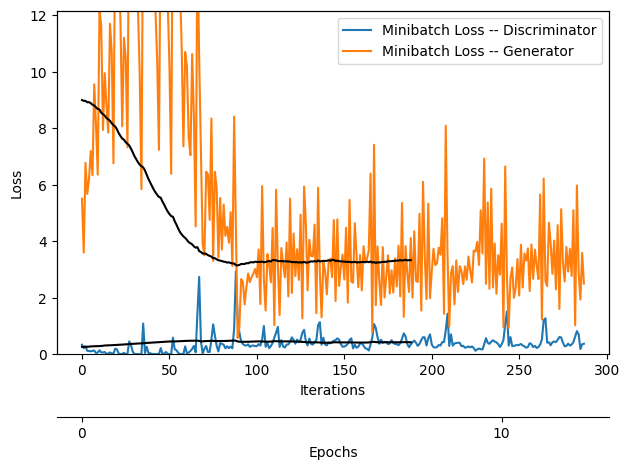

In [53]:
plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS,
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

#### See the quality of images over multiple epochs

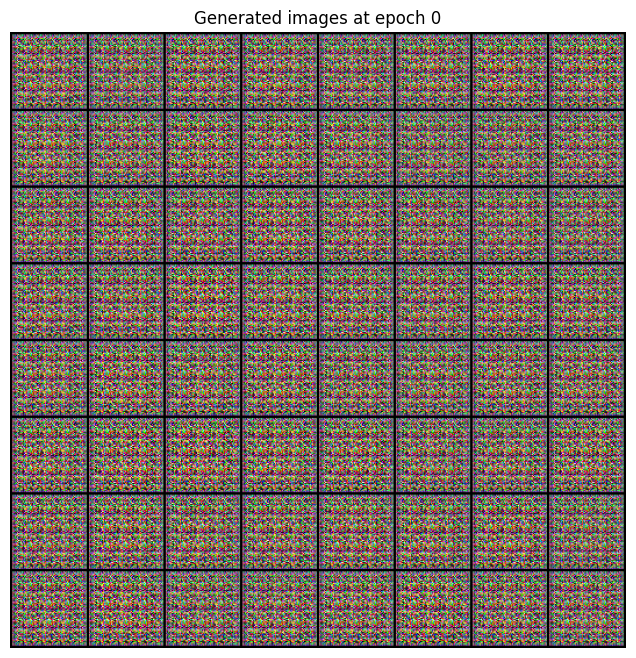

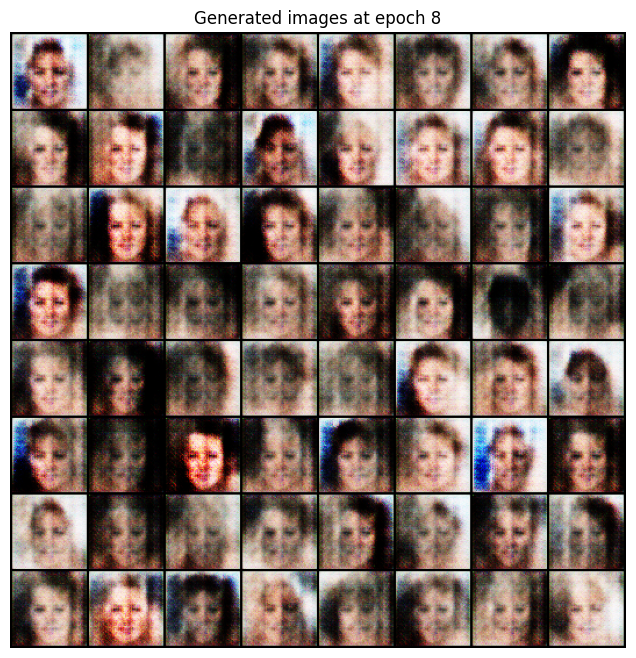

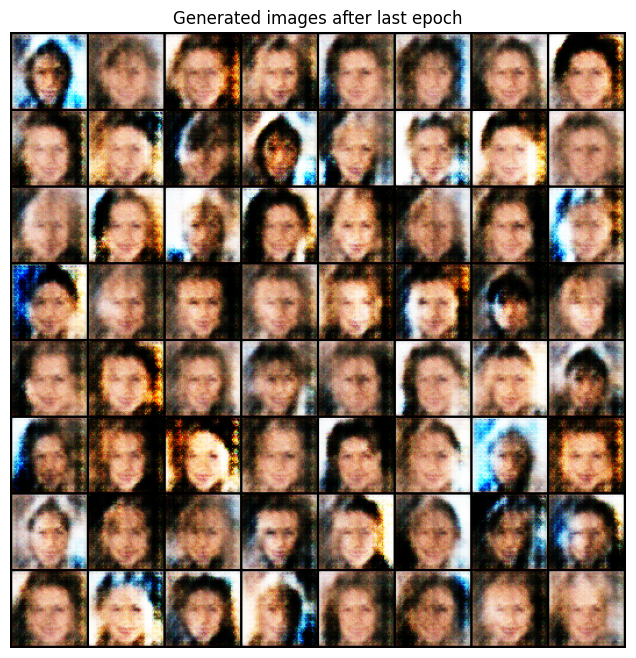

In [55]:
for i in range(0, NUM_EPOCHS, 8):

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()


plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()

### References

1.  ChatGPT
2.  StackOverflow
3.  https://www.analyticsvidhya.com/blog/2021/10/an-end-to-end-introduction-to-generative-adversarial-networksgans/
4.  https://fairyonice.github.io/My-first-GAN-using-CelebA-data.html
